## Import Packages

In [17]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


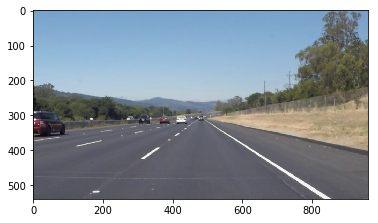

In [18]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [19]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def color_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    gray_img = grayscale(image)
    
    lower_white = np.array([70, 10, 130])
    upper_white = np.array([180, 110, 255])
    
    
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])

    yellow_mask = cv2.inRange(hsv,lower_yellow, upper_yellow)
    white_mask = cv2.inRange(gray_img,200, 255)

    mask_yw = cv2.bitwise_or(white_mask, yellow_mask)
    mask_yw_image = cv2.bitwise_and(gray_img, mask_yw)

    return mask_yw_image
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img,lines):
    #cdstP = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            line_img = cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    return line_img
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

In [20]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'Thumbs.db',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960)


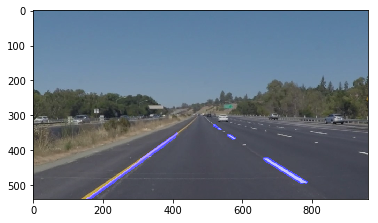

In [22]:
#Test images
swc = "test_images/solidWhiteCurve.jpg"
swr = "test_images/solidWhiteRight.jpg"
syc = "test_images/solidYellowCurve.jpg"
syc2 = "test_images/solidYellowCurve2.jpg"
syl = "test_images/solidYellowLeft.jpg"
wcls = "test_images/whiteCarLaneSwitch.jpg"

image = mpimg.imread(syl)
#plt.imshow(image)

print('This image is:', type(image), 'with dimensions:', image.shape)


gray = grayscale(image)
#plt.imshow(gray, cmap='gray')

masked = color_mask(image)
#plt.imshow(masked, cmap='gray')

print('This image is:', type(masked), 'with dimensions:', masked.shape)
#plt.imshow(gray_img)

low_threshold = 50;
high_threshold = 150;

edges = canny(masked, low_threshold, high_threshold)
print('This image is:', type(edges), 'with dimensions:', edges.shape)
#plt.imshow(edges)

kernel_size = 3
blur_img = gaussian_blur(edges, kernel_size)
#plt.imshow(blur_img)

imshape = image.shape
vertices = np.array([[(150,imshape[0]),(450, 325), (530, 325), (900,imshape[0])]], dtype=np.int32)
roi_img = region_of_interest(blur_img,vertices)
#plt.imshow(roi_img)


rho=1
theta=np.pi/180
threshold = 6
min_line_len=12
max_line_gap = 10

#https://docs.opencv.org/3.4.0/d9/db0/tutorial_hough_lines.html
line_img = hough_lines(roi_img, rho, theta, threshold, min_line_len, max_line_gap)
#plt.imshow(line_img)

weight_img = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
plt.imshow(weight_img)



## Test on Videos

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):

    masked = color_mask(image)
    
    low_threshold = 50;
    high_threshold = 150;

    edges = canny(masked, low_threshold, high_threshold)

    kernel_size = 3
    blur_img = gaussian_blur(edges, kernel_size)

    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(450, 325), (530, 325), (900,imshape[0])]], dtype=np.int32)
    roi_img = region_of_interest(blur_img,vertices)

    rho=1
    theta=np.pi/180
    threshold = 6
    min_line_len=12
    max_line_gap = 10

    line_img = hough_lines(roi_img, rho, theta, threshold, min_line_len, max_line_gap)

    result = weighted_img(line_img, image, α=0.8, β=1., λ=0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [30]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:15<00:00, 15.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 16.9 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left.

In [32]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:49<00:00, 12.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 51 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [34]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:34<00:00,  6.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 38.9 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))